Saving picasso.jpg to picasso (2).jpg


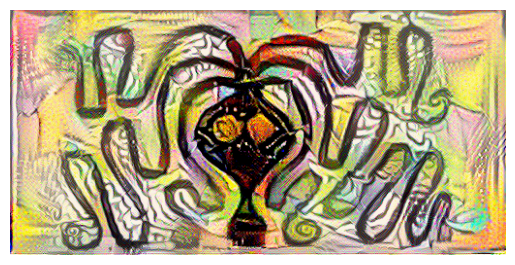

In [8]:
# Neural Style Transfer with TensorFlow and VGG19

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()


# Load and preprocess the images
def load_and_preprocess_image(image_path, max_dim=512):
    img = Image.open(image_path)
    long = max(img.size)
    scale = max_dim / long
    img = img.resize((round(img.size[0] * scale), round(img.size[1] * scale)))
    img = np.array(img)

    img = np.expand_dims(img, axis=0)  # Add a batch dimension
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

# Deprocessing the image to bring it back to RGB space
def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]  # Convert BGR to RGB
    img = np.clip(img, 0, 255).astype('uint8')
    return img

# Define VGG model layers for extracting features
def get_model():
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    content_layers = ['block5_conv2']
    output_layers = style_layers + content_layers
    model = Model([vgg.input], [vgg.get_layer(layer).output for layer in output_layers])
    return model

# Compute content loss
def content_loss(content, target):
    return tf.reduce_mean(tf.square(content - target))

# Compute style loss (gram matrix-based)
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

def style_loss(style, gram_target):
    return tf.reduce_mean(tf.square(gram_matrix(style) - gram_target))

# Total loss
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights

    # Pass image through the model
    model_outputs = model(init_image)
    style_output_features = model_outputs[:5]
    content_output_features = model_outputs[5:]

    style_score = 0
    content_score = 0

    # Style loss
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += style_loss(comb_style, target_style)

    # Content loss
    content_score = content_loss(content_output_features[0], content_features[0])

    # Total loss
    style_score *= style_weight
    content_score *= content_weight

    total_loss = style_score + content_score
    return total_loss

# Run gradient descent
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        loss = compute_loss(**cfg)
    return tape.gradient(loss, cfg['init_image']), loss

# Style Transfer Function
def run_style_transfer(content_path, style_path, num_iterations=1000, style_weight=1e0, content_weight=1e4):
    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    # Load content and style images
    content_image = load_and_preprocess_image(content_path)
    style_image = load_and_preprocess_image(style_path)

    # Extract features
    style_features = model(style_image)[:5]
    content_features = model(content_image)[5:]

    gram_style_features = [gram_matrix(feature) for feature in style_features]

    # Initialize the generated image with content image
    init_image = tf.Variable(content_image, dtype=tf.float32)

    # Optimizer
    opt = tf.optimizers.Adam(learning_rate=5.0, beta_1=0.99, epsilon=1e-1)

    # Loss weights
    loss_weights = (style_weight, content_weight)

    # Config for computing gradients
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }

    # Perform gradient descent
    best_loss, best_img = float('inf'), None
    for i in range(num_iterations):
        grads, loss = compute_grads(cfg)
        opt.apply_gradients([(grads, init_image)])
        clipped_image = tf.clip_by_value(init_image, -127, 127)

        if loss < best_loss:
            best_loss = loss
            best_img = clipped_image.numpy()

    return deprocess_image(best_img)

# Example usage
# You can upload your content and style images to Colab
content_path = 'gobble.png'  # Change this to your content image name
style_path = 'picasso.jpg'

# Run style transfer
output_image = run_style_transfer(content_path, style_path)

# Display the output image
plt.imshow(output_image)
plt.axis('off')
plt.show()
